## pressure_tide
use data at numerical mooring to compare approximate formulation for pressure calculation from data averaged (with harmonic extraction) in time

compute pression using xarray, xgcm (for integration)

Everything is long, I think there are some errors / unefficient coding

# notes aurélien:

- le bug avec le temps a été fixé hier matin

- `dst.coords['time'][t0_ind]` -> `dst.time[t0_ind]`

- `.where((dsi.time>=t0_val) & (dsi.time<t0_val + dt_tser))` -> `.sel(time=slice(t0_val, t0_val + dt_tser))`

- il faut normalement chunk=None dans la verticale pour interp, il faut que nous rajoutions plus d'options de chunks à la création des objets de runs

- le jeu de données est très petit ici: parallélisation nécessaire?

- fi.interp a besoin de données ordonnées selon [z,x/y,x/y] et d'un z0 3D

- il faut qu'on comprenne mieux comment controler la taille des tableaux arrivant depuis apply_ufunc

- get_z needs to be updated in crocosi

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as gp

/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8787') #dashboard_address=':8789'
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:54839 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
root_path = '/home/datawork-lops-osi/aponte/bturb_itide/jet/'
run = 'jet_cfg1_wp6_4km_nodecay_2000a2300j/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=["sta1", "sta2","inst","av"], 
                grid_params=gparams, verbose=True, chunk_time=None)

### fixing a few stuff. WARNING quick & dirty
# time is nan
#r['his'].coords['mytime'] = xr.DataArray(np.arange(r['his']["time"].size), dims=["time"])
grid = r['his'].attrs['xgcm-Grid']
rho0 = r.params['rho0']

Analysing directory /home/datawork-lops-osi/aponte/bturb_itide/jet/jet_cfg1_wp6_4km_nodecay_2000a2300j/
Found 3 segments
Found 12 his files
Found 6 sta1 files
Found 6 sta2 files
Found 6 inst files
Found 3 av files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected y_itide = 400000.0 m
Detected jet_ywidth = 800000.0 m
Detected jet_weight = 0.6
Detected omega = 0.000145444104333 1/s
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his', 'sta1', 'sta2', 'inst', 'av']
Grid size: (L ,M, N) = (258, 722, 50)


In [4]:
### choose time limits
#dt_tser = 50 # time interval in days
#t0_ind = 0 # index of first instant for the time series considered

### initialize dataset
dst = r['sta1']
dsi = r['inst']
dsi = dsi.isel(y_rhoy=abs(dsi.coords['eta_rhoy'] - dst.coords['eta_sta1_rho'].values.squeeze()).argmin().values)

### copy SSH time series from inst into stat
dst['ssh'] = dsi['ssh_y'].rename({'x_rhoy':'x_sta1_rho'}) + 0.*dst['eta_sta1_rho']

# rechunk dst along vertical dimension
dst = dst.chunk({'s_rho': None, 'time': 100*24*2})
dst = dst.persist()

print('dst size in GB= %.2e'%(dst.nbytes/1e9))
dst

dst size in GB= 9.39e-03


<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 50, time: 14400, x_sta1_rho: 1, x_sta1_u: 1, x_sta1_v: 1, y_sta1_rho: 1, y_sta1_u: 1, y_sta1_v: 1)
Coordinates:
    xi_sta1_v            (y_sta1_v, x_sta1_v) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    xi_sta1_rho          (y_sta1_rho, x_sta1_rho) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    eta_sta1_v           (y_sta1_v, x_sta1_v) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    eta_sta1_rho         (y_sta1_rho, x_sta1_rho) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    xi_sta1_u            (y_sta1_u, x_sta1_u) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    eta_sta1_u           (y_sta1_u, x_sta1_u) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * s_rho                (s_rho) float32 -0.99 -0.97 -0.95 ... -0.05 -0.03 -0.01
    time_instant         (time) float64 dask.array<chunksize=(4800,), meta=np.ndarray>
  * time                 (time) float64 2e+03

0.0 0.0


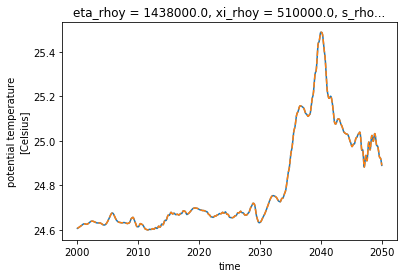

In [5]:
### just checking that time series match: compare surface T
t_stat = dst.T_station1.isel(s_rho=-1) #.persist()
# maybe I could use alignment here
#t_inst = dsi.T_y.where((dsi.time>=t0_val) & (dsi.time<t0_val + dt_tser)).persist()
t_inst = dsi.T_y #.sel(time=slice(t0_val, t0_val + dt_tser))

t_stat.sel(time=slice(2000,2050)).plot()
t_inst.sel(time=slice(2000,2050)).plot(linestyle="--", color="tab:orange")

print((t_stat-t_inst).mean().values, (t_stat-t_inst).std().values)

In [6]:
# vertical integration for pressure computation
def get_pres(grid,z,rho):
    """ compute pressure by integration from the surface, 
    taking rho at rho points and giving results on w points 
    with p=0 at the surface """
    _g = 9.81 # il faudrait arrêter de coder g en dur partout...
    dz = grid.diff(z, "s")
    return _g * grid.cumsum((rho*dz).sortby("s_rho",ascending=False), "s", \
                            to="outer", boundary="fill").sortby("s_w",ascending=False)

def intz_r2w_topdown(x):
    """ s_rho to s_w, from the surface (initial value 0) """
    return grid.cumsum(x.sortby("s_rho",ascending=False), "s", to="outer", boundary="fill")\
                .sortby("s_w",ascending=False)

### this should be in a py module
def interp2z_3d(z0, z, v, b_extrap=2, t_extrap=2):
    """
    b_extrap, t_extrap:
        0 set to NaN
        1 set to nearest neighboor
        2 linear extrapolation
    """
    import crocosi.fast_interp3D as fi  # OpenMP accelerated C based interpolator
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # add dimensions if necessary
    if v.ndim == 1:
        lv = v.squeeze()[:,None,None]
        lz = z.squeeze()[:,None,None]
    elif v.ndim == 2:
        lv = v[...,None]
        lz = z[...,None]
    else:
        lz = z[...]
        lv = v[...]
    #
    return fi.interp(z0.astype('float64'), lz.astype('float64'), lv.astype('float64'), 
                     b_extrap, t_extrap)

def interp2z(z0, z, v, b_extrap, t_extrap):
    ''' interpolate vertically
    '''
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # test if temporal dimension is present
    if v.ndim == 4:
        o=(2, 0, 1)
        vi = [interp2z_3d(np.transpose(z0[...,0], o), 
                          np.transpose(z[...,t], o), 
                          np.transpose(v[...,t], o), 
                          b_extrap, t_extrap)[...,None]
                  for t in range(v.shape[-1])]
        vi = np.concatenate(vi, axis=-1)
        vi = np.transpose(vi, (1, 2, 0, 3))
        return vi
    else:
        return interp2z_3d(z0, z, v, b_extrap, t_extrap).squeeze()

In [7]:
# get z needs to be updated in crocosi

def get_z(run, zeta=None, h=None, vgrid='r', hgrid='r'):
    ''' compute vertical coordinates
        zeta should have the size of the final output
        vertical coordinate should be first
    '''

    ds = run['his']
    N = run.N
    hc = run.params['Hc']

    if zeta is not None:
        _zeta = zeta
    else:
        _zeta = ds.ssh
    if h is not None:
        _h = h
    else:
        _h = ds.h
    #
    if hgrid is 'u':
        _zeta = rho2u(_zeta, ds)
        _h = rho2u(_h, ds)
    elif hgrid is 'v':
        _zeta = rho2v(_zeta, ds)
        _h = rho2v(_h, ds)
    #
    sc=run['his']['sc_'+vgrid]
    cs=run['his']['Cs_'+vgrid]

    #
    z0 = (hc * sc + _h * cs) / (hc + _h)
    z = _zeta + (_zeta + _h) * z0
    #z = np.squeeze(_zeta + (_zeta + _h) * z0)  # this should not be here
    # manually swap dims, could also perform align with T,S
    #if z.ndim ==4:
    #    z = z.transpose(z.dims[0], z.dims[3], z.dims[1], z.dims[2])
    #elif z.ndim == 3:
    #    z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])
    #elif z.ndim == 2:
    #    z = z.transpose(sc.dims[0], _zeta.dims[0])
    return z.rename('z_'+vgrid)

get_z(r, zeta=dst.ssh, h=r['his'].h.mean(), vgrid='r', hgrid='r')

<xarray.DataArray 'z_r' (time: 14400, x_sta1_rho: 1, y_sta1_rho: 1, s_rho: 50)>
dask.array<add, shape=(14400, 1, 1, 50), dtype=float64, chunksize=(4800, 1, 1, 50), chunktype=numpy.ndarray>
Coordinates:
    xi_sta1_rho   (y_sta1_rho, x_sta1_rho) float32 510000.0
    eta_sta1_rho  (y_sta1_rho, x_sta1_rho) float32 1438000.0
    time_instant  (time) float64 2e+03 2e+03 2e+03 ... 2.3e+03 2.3e+03 2.3e+03
  * time          (time) float64 2e+03 2e+03 2e+03 ... 2.3e+03 2.3e+03 2.3e+03
    eta_rhoy      (x_sta1_rho) float32 1438000.0
    xi_rhoy       (x_sta1_rho) float32 510000.0
    fy            (x_sta1_rho) float32 0.00012640547
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
Dimensions without coordinates: x_sta1_rho, y_sta1_rho

In [8]:
# compute vertical levels # in this version I put the new fields in the dataset for dimension consistency
#dst['zr'] = gp.get_z(r, zeta=dst.ssh, h=r['his'].h.mean(), vgrid='r', hgrid='r') #.persist()
#dst['zw'] = gp.get_z(r, zeta=dst.ssh, h=r['his'].h.mean(), vgrid='w', hgrid='r') #.persist()
dst['zr'] = get_z(r, zeta=dst.ssh, h=r['his'].h.mean(), vgrid='r', hgrid='r')
dst['zw'] = get_z(r, zeta=dst.ssh, h=r['his'].h.mean(), vgrid='w', hgrid='r')
dst['dz'] = grid.diff(dst.zw,"s") #.persist() 

In [9]:
### compute basic state pressure: mean z, mean T, mean P
#temp = dst.T_station1.squeeze() #.compute()
#dst['zrmoy'] = gp.get_z(r, zeta=dst.ssh.mean(), h=r['his'].h.mean(), vgrid='r', hgrid='r') #.persist()
#dst['zwmoy'] = gp.get_z(r, zeta=dst.ssh.mean(), h=r['his'].h.mean(), vgrid='w', hgrid='r') #.persist()
dst['zrmoy'] = get_z(r, zeta=dst.ssh.mean('time'), h=r['his'].h.mean(), vgrid='r', hgrid='r') #.persist()
dst['zwmoy'] = get_z(r, zeta=dst.ssh.mean('time'), h=r['his'].h.mean(), vgrid='w', hgrid='r') #.persist()
dst['dzmoy'] = grid.diff(dst.zwmoy, "s") #.persist()

In [11]:
# does not change order in apply_ufunc it seems, weird
#_d = ['time','x_sta1_rho', 'y_sta1_rho', 's_rho']
#_d = _d + [d for d in dst.dims if d not in _d]
#dst = dst.transpose(*_d)

<xarray.DataArray (x_sta1_rho: 1, y_sta1_rho: 1, s_rho: 50, time: 14400)>
dask.array<interp2z, shape=(1, 1, 50, 14400), dtype=float64, chunksize=(1, 1, 50, 4800), chunktype=numpy.ndarray>
Coordinates:
    xi_sta1_rho   float32 dask.array<chunksize=(), meta=np.ndarray>
    eta_sta1_rho  float32 dask.array<chunksize=(), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    eta_rhoy      float32 dask.array<chunksize=(), meta=np.ndarray>
    xi_rhoy       float32 dask.array<chunksize=(), meta=np.ndarray>
    fy            float32 dask.array<chunksize=(), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(4800,), meta=np.ndarray>
  * time          (time) float64 2e+03 2e+03 2e+03 ... 2.3e+03 2.3e+03 2.3e+03
    z_r           (time, s_rho) float64 dask.array<chunksize=(4800, 50), meta=np.ndarray>
Dimensions without coordinates: x_sta1_rho, y_sta1_rho

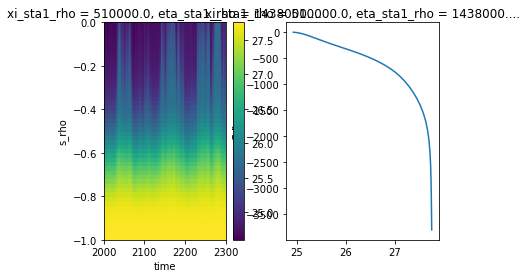

In [10]:
t_interp = xr.apply_ufunc(interp2z, dst.zrmoy, dst.zr, dst.T_station1, 2, 2,
                          dask='parallelized', output_dtypes=[np.float64]).persist()
t_interp = t_interp.assign_coords(z_r=dst.zr.squeeze())

fig, axs = plt.subplots(1, 2)
t_interp.plot(ax=axs[0])
t_moy = t_interp.mean('time').assign_coords(z_r=dst.zrmoy).persist()
t_moy.plot(y="z_r", ax=axs[1])

t_interp


In [11]:
## warning pressure here with s_rho dim but it is actually on w points
p_moyw = get_pres(grid, dst.zwmoy, rho0+t_moy).rename('p_moy').persist() # pressure at w point
p_moyw = p_moyw.assign_coords(z_w=dst.zwmoy)
p_moyw

<xarray.DataArray 'p_moy' (x_sta1_rho: 1, y_sta1_rho: 1, s_w: 51)>
dask.array<mul, shape=(1, 1, 51), dtype=float64, chunksize=(1, 1, 50), chunktype=numpy.ndarray>
Coordinates:
    xi_sta1_rho   (y_sta1_rho, x_sta1_rho) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    eta_sta1_rho  (y_sta1_rho, x_sta1_rho) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    eta_rhoy      (x_sta1_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    xi_rhoy       (x_sta1_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    fy            (x_sta1_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    z_w           (x_sta1_rho, y_sta1_rho, s_w) float64 dask.array<chunksize=(1, 1, 51), meta=np.ndarray>
Dimensions without coordinates: x_sta1_rho, y_sta1_rho, s_w

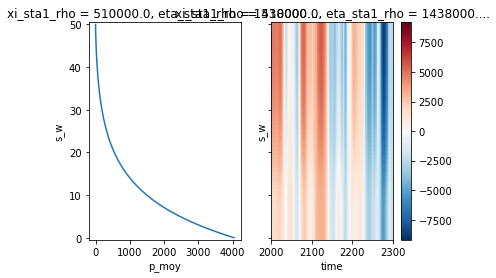

In [12]:
p_w = get_pres(grid, dst.zw, rho0+dst.T_station1).rename('pres').persist()
p_w = xr.apply_ufunc(interp2z, dst.zwmoy, dst.zw.chunk({"s_w":-1}), p_w.chunk({"s_w":-1}), 2, 2,
                          dask='parallelized', output_dtypes=[np.float64]).persist()
p_w = p_w.assign_coords(z_w=dst.zwmoy)

p_anom = p_w - p_moyw

# plot result
fig, axs = plt.subplots(1, 2, sharey=True)
(p_moyw/1e4).plot(y="s_w", ax=axs[0]) # dBar
p_anom.plot(x="time", ax=axs[1])

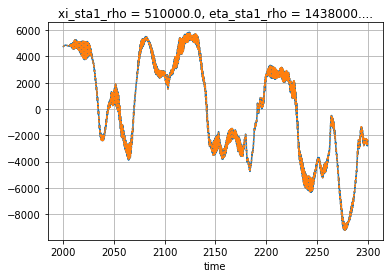

In [13]:
### check that pressure at "mean surface point" corresponds to SSH anomalies
grav = 9.81

p_w.isel(s_w=-1).plot()
((dst.ssh-dst.zwmoy.isel(s_w=-1))*(rho0+t_moy.isel(s_rho=-1))*grav).plot(linestyle=":")
plt.grid(True)

# mean + pert pressure on a finite time window
take a finite time window (e.g. 2 days), compute pressure and separate mean and perturbation
compare with approximate computation based on harmonic extraction


In [25]:
### work on finite time window: extract
indt = 0

dsa = r['his']
tend = dsa.time[indt]
tbeg = tend-1. # I don't know where to get that averaging goes over 1 day
ds = dst.sel(time=slice(tbeg, tend)).persist()

### WARNING this is not robust at all (to find indices of station)
### I should be able to find those grid indices directly in the station dataset
indy, indx = np.unravel_index(((dsa.eta_rho-ds.eta_sta1_rho)**2+(dsa.xi_rho-ds.xi_sta1_rho)**2).argmin(), 
                       dsa.eta_rho.shape)
dsa = dsa.isel(x_rho=indx,y_rho=indy,time=[indt])

omega = r.params['omega'] * 24 * 3600 # rad/day
tt = ds.time #- ds.time.isel(time=0)
print("length of time series:", ds.dims['time'], ds.nbytes/1e6, "Mo")

grav = 9.81
h0 = r['his'].h.mean()
znot = get_z(r, zeta=dsa.ssh_a*0, h=h0, vgrid='r', hgrid='r').persist()

length of time series: 48 0.090724 Mo


CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 57.5 ms


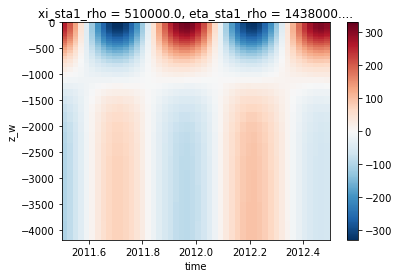

In [26]:
### compute mean stratif and pressure
zrmoy = get_z(r, zeta=ds.ssh.mean("time"), h=r['his'].h.mean(), vgrid='r', hgrid='r')
zwmoy = get_z(r, zeta=ds.ssh.mean("time"), h=r['his'].h.mean(), vgrid='w', hgrid='r')
zr = get_z(r, zeta=ds.ssh, h=r['his'].h.mean(), vgrid='r', hgrid='r')
zw = get_z(r, zeta=ds.ssh, h=r['his'].h.mean(), vgrid='w', hgrid='r')

ti = xr.apply_ufunc(interp2z, zrmoy, zr, ds.T_station1, 2, 2,
                          dask='parallelized', output_dtypes=[np.float64])
tmoy = ti.mean("time").assign_coords(z_r=zrmoy.squeeze()).persist()
tmo_noi = ds.T_station1.mean("time") # no prior interpolation

### compute inst pressure
pres = get_pres(grid, ds.zw, rho0+ds.T_station1)
pres = xr.apply_ufunc(interp2z, zwmoy, zw.chunk({"s_w":-1}), pres.chunk({"s_w":-1}), 2, 2,
                          dask='parallelized', output_dtypes=[np.float64])
pres = pres.assign_coords(z_w=zwmoy).persist()
pmoy = pres.mean("time")
pmo_noi = get_pres(grid, zwmoy, rho0+tmo_noi)

### compute anomalies
tano = ds.T_station1 - tmoy
pano = pres - pmoy

%time pano.plot(y="z_w")

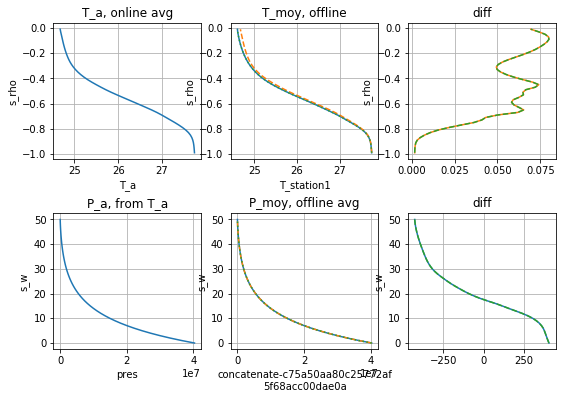

In [27]:
# plot mean pressure from mean T and compare with offline computation
# also compare offline average with and without prior interpolation

dsa['zr'] = get_z(r, zeta=dsa.ssh_a, h=r['his'].h.mean(), vgrid='r', hgrid='r').persist()
dsa['zw'] = get_z(r, zeta=dsa.ssh_a, h=r['his'].h.mean(), vgrid='w', hgrid='r')

# interpolate temperature
tai = xr.apply_ufunc(interp2z, zrmoy.squeeze(), dsa.zr.squeeze(), dsa.T_a.chunk({"s_rho":-1}).squeeze(), 2, 2,
                          dask='parallelized', output_dtypes=[np.float64]).persist()
pav = get_pres(grid, dsa.zw, rho0+dsa.T_a).rename('pres')
pai = xr.apply_ufunc(interp2z, zwmoy.squeeze(), dsa.zw.squeeze(), pav.chunk({"s_w":-1}).squeeze(), 2, 2,
                          dask='parallelized', output_dtypes=[np.float64]).persist()

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(9,6))
dsa.T_a.plot(ax=axs[0,0], y="s_rho")
tmoy.plot(ax=axs[0,1], y="s_rho")
tai.plot(ax=axs[0,1], y="s_rho", linestyle="--")
tmo_noi.plot(ax=axs[0,1], y="s_rho", linestyle=":")
(tai- tmoy).plot(ax=axs[0,2], y="s_rho", color="C1")
(tai- tmo_noi).plot(ax=axs[0,2], y="s_rho", linestyle="--", color="C2")

pav.plot(ax=axs[1,0], y="s_w")
pmoy.plot(ax=axs[1,1], y="s_w")
pai.plot(ax=axs[1,1], y="s_w", linestyle="--")
pmo_noi.plot(ax=axs[1,1], y="s_w", linestyle=":")
(pai-pmoy).plot(ax=axs[1,2], y="s_w")
(pai- pmo_noi).plot(ax=axs[1,2], y="s_w", linestyle="--", color="C2")

titles = ['T_a, online avg', 'T_moy, offline', 'diff', 'P_a, from T_a', 'P_moy, offline avg', 'diff']
for ia,ax in enumerate(axs.ravel()):
    ax.grid(True)
    ax.set_title(titles[ia])
fig.subplots_adjust(hspace=.4)

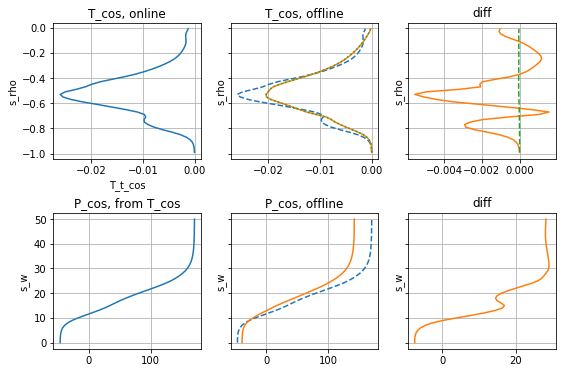

In [30]:
### harmonic extraction : compute offline from inst fields and compare with online extraction

### compute cos extraction
tcos = (ti * np.cos(omega*tt)).mean("time")
tco_noi = (ds.T_station1 * np.cos(omega*tt)).mean("time") # neglect grid breathing
pcos = (pano * np.cos(omega*tt)).mean("time")

tcoi = xr.apply_ufunc(interp2z, zrmoy.squeeze(), dsa.zr.squeeze(), dsa.T_t_cos.chunk({"s_rho":-1}).squeeze(), 2, 2,
                          dask='parallelized', output_dtypes=[np.float64]).persist()


### no correction
pcoi = grav*(rho0+dsa.T_a.isel(s_rho=-1))*dsa.ssh_t_cos + get_pres(grid, dsa.zw, dsa.T_t_cos)
pcoi = xr.apply_ufunc(interp2z, zwmoy.squeeze(), dsa.zw.squeeze(), pcoi.chunk({"s_w":-1}).squeeze(), 2, 2,
                          dask='parallelized', output_dtypes=[np.float64]).persist()

### plot result
fig, axs = plt.subplots(2, 3, sharex=False, sharey="row", figsize=(9,6))
dsa.T_t_cos.plot(ax=axs[0,0], y="s_rho")
tcoi.plot(ax=axs[0,1], y="s_rho", linestyle="--") # there is hardly no difference
tcos.plot(ax=axs[0,1], y="s_rho")
tco_noi.plot(ax=axs[0,1], y="s_rho", linestyle=":")
(tcoi- tcos).plot(ax=axs[0,2], y="s_rho", color="C1")
(tco_noi - tcos).plot(ax=axs[0,2], y="s_rho", linestyle="--", color="C2", label="no z(t)")

pcoi.plot(ax=axs[1,0], y="s_w")
pcoi.plot(ax=axs[1,1], y="s_w", linestyle="--")
pcos.plot(ax=axs[1,1], y="s_w")
(pcoi-pcos).plot(ax=axs[1,2], y="s_w", color="C1")

titles = ['T_cos, online', 'T_cos, offline', 'diff', 'P_cos, from T_cos', 'P_cos, offline', 'diff']
for ia,ax in enumerate(axs.ravel()):
    ax.grid(True)
    ax.set_title(titles[ia])
fig.subplots_adjust(hspace=.4)

In [ ]:
# what this tells me is that I might not be looking at the correct instant...
temp = ds.T_station1
tsi_noi = (temp * np.sin(omega*tt)).mean("time") # neglect grid breathing

(temp-temp.mean("time")).isel(s_rho=25).plot(marker=".", color="k", label="tseries")

(2*tco_noi.isel(s_rho=25)*np.cos(omega*tt)).plot(label="cos offline")
(2*dsa.T_t_cos.isel(time=0,s_rho=25)*np.cos(omega*tt)).plot(linestyle="--", label="cos online")

(2*tsi_noi.isel(s_rho=25)*np.sin(omega*tt)).plot(label='sin offline')
(2*dsa.T_t_sin.isel(time=0,s_rho=25)*np.sin(omega*tt)).plot(linestyle="--", label="sin online" )

(2*tco_noi.isel(s_rho=25)*np.cos(omega*tt)+2*tsi_noi.isel(s_rho=25)*np.sin(omega*tt)).plot(color="grey", label="reco offline")
(2*dsa.T_t_cos.isel(time=0,s_rho=25)*np.cos(omega*tt)+2*dsa.T_t_sin.isel(time=0,s_rho=25)*np.sin(omega*tt)).plot(linestyle="--", color="grey", label="reco_online")

plt.legend(bbox_to_anchor=(1,1))

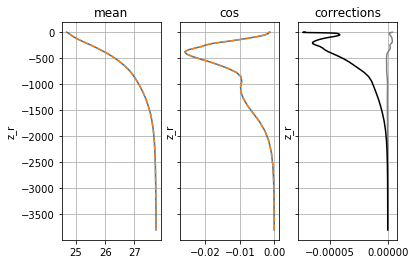

In [47]:
### add corrections for grid breathing: it changes nothing
tcos_online = dsa.T_t_cos.assign_coords(z_r=zrmoy.squeeze()).chunk({"s_rho":-1})
tsin_online = dsa.T_t_sin.assign_coords(z_r=zrmoy.squeeze()).chunk({"s_rho":-1})
tmoy_online = dsa.T_a.assign_coords(z_r=zrmoy.squeeze()).chunk({"s_rho":-1})
# compute correction for mean rho
cormoy = (tcos_online.differentiate("z_r")*dsa.ssh_t_cos +\
        tsin_online.differentiate("z_r")*dsa.ssh_t_sin) * (1+znot/h0)
tcoy = dsa.T_a - cormoy

# compute correction for online cos rho
corcos = tmoy_online.differentiate("z_r")*dsa.ssh_t_cos*(1+znot/h0)
tcor = dsa.T_t_cos - corcos

fig, axs = plt.subplots(1, 3, sharey=True)
tmoy_online.plot(ax=axs[0], y="z_r")
tcoy.plot(ax=axs[0], linestyle='--', y="z_r")
tcos_online.plot(ax=axs[1], y="z_r")
tcor.plot(ax=axs[1], linestyle='--', y="z_r")
cormoy.plot(ax=axs[2], y="z_r", color="grey")
corcos.plot(ax=axs[2], y="z_r", color="k")
tits = ['mean', 'cos', 'corrections']
for ax,tit in zip(axs,tits):
    ax.grid(True)
    ax.set_title(tit)